# How to use ?
In this section, I will walk you through the procedures of using PINN to solve 1d or 2d Poisson equations, either using full batch or mini-batch. I will fill in more technical and implementation details in later sections.
### 2D Poisson
All experiments that use PINN to solve 2D Poisson Eqaution are in the 2D_poisson folder. In this section, I will walk you through how to tune the hyperparameters and run all the experiments in the 2D_poisson folder.
#### 1. Set the Truth Function and Its Laplacian
Before building the Neural Network and doing any optimization, please define the truth function and its divergence. Please define the truth function in the beginning of PINN2D_tool.py. The user defined function should take two arguments x, y and return one value. It should be noted that this function should be able to act on numpy.ndarray array of shape (N, 2) in en element wise manner and returns a numpy array of shape (N,). This truth function is never used in the training process of any PINN. Rather, it is only used when plotting the truth solution as a comparison to the PINN solution. I provided four truth solution functions in the PINN2D_tool.py file: $u_1, u_2, u_3, u_4$. For example $u_1$:

In [2]:
def u1(x, y):
    return np.sin( np.pi * x) * np.sin( np.pi * y)

It should be noted that the function can act on a numpy.ndarray of shape (N, 2) elementwise. 

After defining the truth function, define the correspondant Laplacian. For example, if you defined $u_1$ as your intended truth solution, you need to define a function $div_1$ that is Laplacian of $u_1$:
$$div_1 (x, y) = \nabla^2 u_1(x, y) = u_{1xx}(x, y) + u_{1yy}(x, y)$$

This function should take two inputs as the 2D coordinate of a data point and returns the Laplacian of the function defined before at this particular data point. Similarly, this function should also be able to take numpy.ndarray of shape (N, 2) as input and returns the elementwise operation of the Laplace operator on each data points. For example, after defining u1 above, we should define:

In [3]:
#this is the analytical laplacian of u1
def div1(x, y):
    return -2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

This function is used in the training process of the PINN solving 2D Poisson Equation. In a real setting, this Laplacian is the only known. 

After defining the truth function and the Laplacian operator, you need to seed a few global variables in the PINN2D_tool.py file. Note that every time you change the truth function, you need to update these gloabl variables, otherwise the PINN will be solving another Poisson equation.

Set the __func_RHS__ as the function handle of the truth function you defined. Set __div__ to be the function handle of the divergence of the function you defined. Set __min_val__ to be the minimum value of the truth function you defined. Set __max_val__ to be the maximum value of the truth function you defined. These two variables are only used for plotting purposes.

For example, if you decide to use u1 as the truth function, you should define the global variables in the following way:

In [5]:
##change these two lines if you want to use other functions
func_RHS = u1 ##set this variable to the function of true solution
div = div1 ##set this variable to be the divergence of the above function 
min_val = -2; max_val=2 ##set the minimum and maximum values of the function

#### 2. Pre-Setting
Before defining the PINN or doing any optimization, you need to set the following hyperparameters and variables in the experiment files. 

- n_iter: the number of iterations you wish to complete
- alpha: damping factor for the kernel matrix (only applicable to natural gradient descent algorithms)
- gamma: the weight you give to the boundary condition loss (will be covered in more detail later.)
- write_pickle: if set to True, after the experiment, the PINN object will be serialized and saved into a .dat file, which can be read in another experiment to resume the previous experiment.If set to false, the object will not be saved after the experiment is finished.
- read_pickle: Decides whether to resume a previous experiment. If you want to resume a previous experiment, please set this variable to be the link to the .dat file of the PINN object saved from the previous experiment. If you don't need to resume a previous experiment, please set this variable to None.
- random_seed: The random seed you wish to use to initialize the parameters of the PINN.
- N: set it to be the number of grid data points you wish to use in each dimention of the frame.
- layers: numpy.ndarray object. Set it to your intended shape of the PINN.


#### 3. Running the Experiment
Just type __python filename.py__ in the terminal to run the expriments after setting the hyperparameters. 
Our code provides the following Algorithm: $L^2$, $H^1$, $H^{-1}$, $\dot{H}^1$, $\dot{H}^{-1}$, Fisher-Rao, $W_2$ natural gradient descent, standard gradient descent, L-BFGS-B optimizer in the following files respectively:

- GaussNewton_2dPoisson.py
- H1_2dPoisson.py
- Hinv_2dPoisson.py
- H1semi_2dPoisson.py
- Hinvsemi_2dPoisson.py
- FR_2dPoisson.py
- W2_2dPoisson.py
- GD_2dPoisson.py
- BFGS-2dPoisson.py

# PINN Solving 2D Poisson Equation Overview


## True Solution
You can set any truth solution, just define the function in the PINN2D_tool.py file. My code provides two functions to test. The first one has zero boundary condition, whereas the second has uniform boundary condition of 3. We use different truth solutions for different optimization methods: 
The solution of the function for standard gradient descent, Gauss Newton, $H^1$, $H^{-1}$, $\dot{H}^1$, $\dot{H}^{-1}$ natural gradient descent is:
$$u(x, y) = sin(\pi x)sin(\pi y) + sin(3\pi x)sin(3\pi y)$$
For Fisher-Rao and $W_2$ natural gradient descent, the truth function is:
$$u(x, y) = sin(\pi x)sin(\pi y) + sin(3\pi x)sin(3\pi y)+ 3$$

We used a different truth solution to impose a uniform boundary conditino of 3 because Fisher-Rao and $W_2$ natural gradient descent require that the function in this case $u$ is strictly positive everywhere. 

## Poisson Equation 
All 7 algorithms have the same 2D Poisson equation and the same RHS function f:
$$u_{xx} + u_{yy} = f = -2\pi^2sin(\pi x)sin(\pi y) - 18\pi^2 sin(3\pi x)sin(3\pi y)$$

## Data and Discretization
The data frame we use is a square: $[-1, 1] \times [-1, 1]$. We evenly discretize this frame into 50 by 50 data points. We have 196 boundary points and 2304 colocation points. The plot of the data points are shown below.

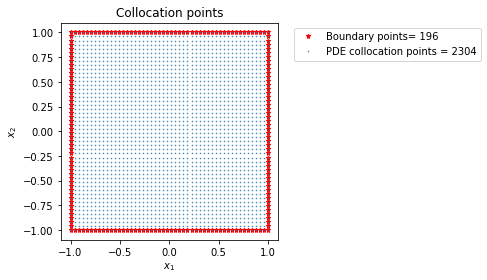

In [2]:
from PINN2D_tool import *
X_f_train, X_u_train, u_train = gridData(50)
plotData(X_f_train, X_u_train)

The input of the PINN is a numpy array of shape (2500, 2). We flattened this data points matrix into a 1d array, in which every element is a 2d coordinate of one data point. The PINN acts on this input array in an elementwise way. The output of the PINN will be a numpy array of shape (2500,), which is the evaluation of the PINN on each data points. 

The order we align the data points in the flattened 1d representation of the data points is important because it determines how we will compute the divergence and laplacian matrix. The way we flattened the data pints is columnwise, bottom to top and left to right. i.e. we iterate through all columns in the data matrix from left to right and in each column, we iterate each element from bottom to top. 

## Loss Function Definition
The loss function is created by a linear combination of the loss of colocation points and boundary points. Suppose the colocation loss is $loss_{f}$ and the boundary points loss is $loss_u$, the total loss is:
$$loss = \gamma  loss_u + (2-\gamma)  loss_f$$

### Colocation Loss $loss_f$
Suppose we have N colocation points (i.e. interior points), the colocation loss is defined to be the MSE of the numerical Laplacian of the function $u$ at each colocation points and the real Laplacian $f$ defined in the Poisson Equation section above. Suppose $\{ (x_i, y_i) \}_{i=1}^N$ are the colocation points, then the colocation loss is:

$$loss_f = \frac{1}{N}\sum_{i=1}^N || u_{xx}(x_i, y_i) + u_{yy}(x_i, y_i) - f(x_i, y_i)||^2$$

The Laplacians of each colocation points are computed using the tensorflow.GradientTape method.

### Boundary Condition Loss $loss_u$
Suppose we have n boundary points, the boundary condition loss is defined to be the MSE of the evaluations of the PINN on boundary points and the real boundary value. Suppose the boundary truth value is B, then:

$$loss_u  = \frac{1}{n}\sum_{i=1}^n || u(x_i, y_i) - B||^2$$

## PINN Architecture
We used PINN of shape (2, 20, 30, 20, 1). The activation functions are all tanh function. However, you can use any shape in the PINN, just input different layer shapes as a numpy array. 

### Parameter Initialization
The weights of the PINN are initialized using Gaussian distributions. For weights $w$ between two layers, in which input dimension is $d_1$ and output dimension is $d_2$, $w$ satisfies:
$$w \sim N(0, \frac{2}{d_1 + d_2})$$

For Gauss Newton, $H^1$, $H^{-1}$, $\dot{H}^1$, $\dot{H}^{-1}$ natural gradient descent, the biases are all initialized to be 0. For Fisher-Rao and $w_2$ natural gradient descent, all biases are initialized to bw zero, except the biases in the last layer, which are inialized to be 3. 

We use a random seed to generate these weights parameters. Fixing the random seed, the initial parameter of the PINN are identity for all algorithms and experiments. But note that the biases in the last layer for Fisher-Rao and $W_2$ natural gradient descent are different from other algoroithms. 

## Newton-cg framework and Kernel Matrix
For all the experiments in the 2D_poisson folder, we use scipy.optimize.minize's 'newton-cg' framework to conduct the standard gradient descent, $L_2$, $H^1$, $H^{-1}$, $\dot{H}^1$, $\dot{H}^{-1}$, Fisher-Rao, $W_2$ natural gradient descent.The documentation for this framework can be reviewed here: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html#optimize-minimize-newtoncg.

Originally, this framework is for minimization of scalar function of one or more variables, using the Newton-CG algorithm. Basically, it takes a Hessian matrix H and computes the descent direction $\eta$ such that:
$$H\eta = -\frac{d\rho}{d\theta}$$
where $\rho$ is the scalar loss function and $\theta$ is a vector of all the trainable parameters of the PINN, the RHS is the negative gradient of the loss function w.r.t. all the parameters of the PINN.

The optimizer does not solve for the $\eta$ directly, rather it uses a iterative numerical method to compute the descent direction. Then, instead of fixed step size, the framework optimizes the step size in each iteration and does the descent iteration using the computed descent direction and optimized step size.

In our case, we expanded the usage of this framework by using the kernel matrix of many natural gradient descent as the input Hessian matrix. Using this framework, we do not need fixed step size because the step size of each iteration is optimized. 

### Divergence and Negative Laplacian Operator Matrix
Before diving into the kernel matrix of any natural gradient descent algorithm, first I will show you how I discretized the divergence operator and the negative laplacian operator, which are both important in computing some kernel matrices.

#### Divergence Operator 
The discretized version of the Divergence Operator as a matrix is defined in the Cn method in the PINN2D_tool.py file. We used finite differentiation method to discretize the divergence operator. It should be noted that this discretized divergence operator assumes zero bounday condition in the truth function $u$, which is generally satisfied in all of our 2D poisson PINN examples except the ones using Fisher-Rao and $W_2$ natural gradient descent algorithm because they use uniform non-zero boundary condition (in our case 3). It can be a problem, but will only affect a small portion of the divergence of the entire data points, especially when the number of data points is large. But we need a new version of the divergence operator such that nothing is broken. We will update it in the future version.

Suppose there are N data points in each dimension in the dataframe, i.e. $N^2$ data points in total and $(N-2)^2$ colocation points. The divergence matrix $C \in \mathbb{R}^{2(N-2)^2 \times (N-2)^2}$ acts on a vector $\vec{v} \in \mathbb{R}^{(N-2)^2}$, which is the evaluation of any 2D vector function $g$ (in our case the PINN function or the truth function u) evaluated at the $(N-2)^2$ colocation points and returns a vector in $\mathbb{R}^{2(N-2)^2}$. The first half of this output vector is the gradient of $g$ w.r.t. x evaluated at all the colocation points and the second half of the output vector is the gradient of $g$ w.r.t. y evaluated at all the colocation points:

$$C\vec{v} = \begin{bmatrix}
g_x \\ 
g_y
\end{bmatrix}$$

In real implementation, we used finite differentiation to achieve this. 

For example, suppose $N=4$, then the discretized divergence operator $C \in \mathbb{R}^{8 \times 4}$ and is constructed in the following way:

1. Instantiate matrix $A = \begin{bmatrix} 0 & 1 & 0 & 0 \\-1 & 0 & 1 & 0 \\ 0 & -1 & 0 & 1 \\ 0 & 0 & -1 & 0\end{bmatrix}$
2. Compute $A_1 = \frac{1}{2dx}I_4 \bigotimes A$, where $\bigotimes$ is the Kronecker product, $I_4$ is the identity matrix and $dx$ is the horizontal distance between each data points.
3. Compute $A_2 = \frac{1}{2dy}A \bigotimes I_4$, where $dy$ is the vertical distance between each data points.
4. Vertically concatenate $A_1, A_2$ to obatain $C = \begin{bmatrix} A_1 \\ A_2 \end{bmatrix}$

#### Negative Laplace Operator
The discretized negative Laplace Operator matrix is defined in the method NegLaplacian in PINN2D_tool.py. This method takes N, the number of grid points in each dimension as the input and returns the matrix $L \in \mathbb{R}^{N^2 \times N^2}$, that is equivalent to the following operator:
$$-\nabla^2 f = - \frac{\partial{^2f}}{\partial{x^2}} - \frac{\partial{^2f}}{\partial{y^2}}$$
where $f$ is 2D scalar function whose domain is discretized. Suppose $\vec{v} \in \mathbb{R}^{N^2}$ is the evaluation of function $f$ over all the discretized data points in the frame and the order is the same as the order described before, then $L$ acting on $\vec{v}$ returns a vector in $\mathbb{R}^{N^2}$ of which each element is the negative laplacian of the function $f$ evaluated at each data point.

In real implementation, we first compute the divergence operator matrix $C$. Then, we construct an identity matrix of size $\mathbb{R}^{N^2 \times N^2}$. For the columns and rows that correspond to the colocation points, we copy $C^T C$ to it and get the resulting matrix as $L$.

#### Standard Gradient Descent
To achieve standard gradient, we set $H = I$ indentity matrix, in the newton-cg framework such that:

$$\eta = -\frac{d\rho}{d\theta}$$

#### $L^2$ Natural Gradient Descent
The kernel matrix of $L^2$ natural gradient descent is:
$$G_{L^2} = \alpha I + J^TJ$$
where $J$ is the Jacobian of the PINN function w.r.t. all parameters. $\alpha$ is the damping factor of the kernel. By default, damping factor is set to 0. In occation that there are more parameters then data points, $J^T J $ will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{L^2}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the $L^2$ descent direction:

$$G_{L^2} \eta^{L^2}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The $L^2$ natural gradient descent is then performed with optimized step size.

#### $H^1$ Natural Gradient Descent 
The kernel matrix of $H^1$ natural gradient descent is:
$$G_{H^1} = \alpha I + J^T (I + L) J$$
where $J$ is the Jacobian of the PINN function w.r.t. all parameters. $L$ is the diecretized negative divergence operator matrix. $\alpha$ is the damping factor. By default, damping factor is set to 0. In occation that there are more parameters then data points, the kernel will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{H^1}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the $H^1$ descent direction:

$$G_{H^1} \eta^{H^1}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The $H^1$ natural gradient descent is then performed with optimized step size.

#### $\dot{H}^1$ Natural Gradient Descent
The kernel matrix of $\dot{H}^1$ natural gradient descent is:
$$G_{\dot{H}^1} = \alpha I + J^T L J$$
where $J$ is the Jacobian of the PINN function w.r.t. all parameters. $L$ is the diecretized negative divergence operator matrix. $\alpha$ is the damping factor. By default, damping factor is set to 0. In occation that there are more parameters then data points, the kernel will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{\dot{H}^1}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the $\dot{H}^1$ descent direction:

$$G_{\dot{H}^1} \eta^{\dot{H}^1}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The $\dot{H}^1$ natural gradient descent is then performed with optimized step size.

#### $H^{-1}$ Natural Gradient Descent 
The kernel matrix of $H^{-1}$ natural gradient descent is:
$$G_{H^{-1}} = \alpha I + J^T (I + L)^{-1} J$$
where $J$ is the Jacobian of the PINN function w.r.t. all parameters. $L$ is the diecretized negative divergence operator matrix. $\alpha$ is the damping factor. By default, damping factor is set to 0. In occation that there are more parameters then data points, the kernel will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{H^{-1}}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the $H^{-1}$ descent direction:

$$G_{H^{-1}} \eta^{H^{-1}}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The $H^{-1}$ natural gradient descent is then performed with optimized step size.

#### $\dot{H}^{-1}$ Natural Gradient Descent
The kernel matrix of $\dot{H}^{-1}$ natural gradient descent is:
$$G_{\dot{H}^{-1}} = \alpha I + J^T L^{-1} J$$
where $J$ is the Jacobian of the PINN function w.r.t. all parameters. $L$ is the diecretized negative divergence operator matrix. $\alpha$ is the damping factor. By default, damping factor is set to 0. In occation that there are more parameters then data points, the kernel will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{\dot{H}^{-1}}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the $\dot{H}^{-1}$ descent direction:

$$G_{\dot{H}^{-1}} \eta^{\dot{H}^{-1}}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The $\dot{H}^{-1}$ natural gradient descent is then performed with optimized step size.

#### Fisher-Rao Natural Gradient Descent
The kernel matrix of Fisher-Rao Natural gradient descent is:
$$G_{FR} = \alpha I + J^T \Phi J$$

$J \in \mathbb{R}^{N^2 \times p}$ where $N^2$ is the total number of data points and p is the number of all parameters of PINN. $\Phi \in \mathbb{R}^{N^2 \times N^2}$ is a diagonal matrix whose diagonal is the inverse of the evaluations of the PINN on the $N^2$ data points. $\alpha$ is the damping factor. By default, damping factor is set to 0. In occation that there are more parameters then data points, the kernel will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{FR}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the Fisher-Rao descent direction:

$$G_{FR} \eta^{FR}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The Fisher-Rao natural gradient descent is then performed with optimized step size.

#### $W^2$ Natural Gradient Descent
The kernel matrix of Wasserstein Natural Gradient Descent is:
$$G_{W^2} = \alpha I + J^T(C^T U C)^{-1} J$$
$J$ is the Jacobian of the PINN over all colocation points w.r.t. all parameters of PINN. $J \in \mathbb{R}^{(N-2)^2 \times p}$, where p is the number of parameters of PINN and N is the number of data points in each dimention of the discretized frame. The matrix $C \in \mathbb{R}^{2(N-2)^2 \times (N-2)^2}$ is the matrix of discretized divergence operator defined in the Cn method $U \in \mathbb{R}^{2(N-2)^2 \times 2(N-2)^2}$ is a diagonal matrix whose diagonal is the evaluation of the PINN over all colocation points repeating twice in the same order. 

$\alpha$ is the damping factor. By default, damping factor is set to 0. In occation that there are more parameters then data points, the kernel will be singular and it is preferable to add a non-zero damping factor such that the kernel matrix can be inverted.

We input this kernel $G_{W^2}$ to the newton-cg framework as the $H$ matrix such that the following equation is solved iteratively for the Fisher-Rao descent direction:

$$G_{W^2} \eta^{W^2}_{nat} = -\frac{\partial \rho}{\partial \theta}$$

The Wassertein natural gradient descent is then performed with optimized step size.


## Hyperparameters
#### Weight $\gamma$ in loss function
The loss function is created by a linear combination of the loss of colocation points and boundary points. Suppose the colocation loss is $loss_{f}$ and the boundary points loss is $loss_u$, the total loss is:
$$loss = \gamma  loss_u + (2-\gamma)  loss_f$$
Since there is a magnitude separation between the boundary loss and the colocation loss, we use $\gamma = 1.99$ to add more weights on the boundary points to impose the boudnary condition.

#### Number of iterations
We did 2000 iterations for all 7 algorithms.

#### Damping factor
We used damping factor $\alpha=0$ for all natural gradient descent algorithms.

#### Random Seed
We use random seed 0 to generate the initial parameters.